# 예지 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장이 나면 보수를 하는 것
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것
- 예제
 - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측
 - 회귀모델과 분류모델
 - RF와 LSTM 비교
 - 시계열 특성 추가 방법

## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

## PM 분류 모델 (다중  분류)
- U (Unsafe): 위험한 상태를 2개 이상으로 분류
- U 값이 0/1/2 세가지를 갖는 다중 분류 모델로 구현

<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.45.50.png?raw=1" align='left'>

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import keras
from keras import Sequential
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier, LGBMRegressor
from keras.layers import Dropout, LSTM, Dense, Activation
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# 데이터
- 훈련 데이터에는 엔진별 가동 데이터와 수명정보가 있고
- 테스트 데이터에는 엔진 가동 정보만 있고 정답은 (향후 잔여수명)은 별도의 truth 데이터로 제공한다

- 컬럼 (변수) 설명
 -	__id__: 엔진 ID (1~100)
 -	__cycle__: 엔진별 운행 시퀀스 번호, (1~ 고장시점 까지)
 -	__setting1__ to __setting3__: 엔진 운영 설정 변수
 -	__s1__ to __s21__: 센서 값


In [ ]:
# 훈련 데이터
train_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
# 테스트 데이터
test_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
# 정답 (테스트데이터의 잔여 수명) 데이터
truth_df = pd.read_csv('http://azuremlsamples.azureml.net/templatedata/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
train_df = train_df.sort_values(['id','cycle'])

## 레이블(y) 컬럼 추가
- 회귀 분석에서는 잔여시간(TTF)을 예측하며 각 상태(State) 값을 보고 앞으로 남은 잔여시간을 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 특정 기간 이내에 고장 날지 여부를 예측한다
 - 이진 분류: 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
 - 다중 분류: 예를 들어 30 사이클 이내에 고장이 날지 또는 15 사이클 이내 고장이 날지를 나누어 예측한다 (0/1/2 구분)
- 회귀 및 분류를 위한 레이블을 만들겠다

- RUL(Remaining Useful Life)
 - 같은 엔진 ID에 대해서 최대 cycle 값이 "수명"을 나타낸다
 - 이 수명값을 rul 데이터프레임에 저장한다
 - 같은 엔진들 즉 같은 'id'를 같는 행들을 각각 별도의 데이터프레임으로 만드는 groupby를 사용한다

In [ ]:
# 모든 행에 대해서 잔여수명 레이블 추가
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


- 각 행별로 잔여 수명 (RUL)은, 각 엔진별 rul 테이블의 수명에서 현재 시각인 cycle 값을 뺀 값이다
- rul 데이터프레임에서 수명을 나타내는 cycle 컬럼 이름을 max라고 바꾸겠다
- 잔여 수명을 나타내는 'RUL' 컬럼을 추가한다

In [ ]:
rul

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


## 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다
 - bnc (binary classifiation)
- 다중 분류를 위해서, 앞으로 30 및 15 사이클 이내에 고장이 날 지를 구분하는 다중 분류용 레이블을 만든다
 - mcc (multi-class classification)

In [ ]:
# 이진분류, 삼진 분류를 위한 레이블
w1 = 30 # 10 또는 50인 경우와 비교
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다
- cycle 값을 하나 복사하여 스케일링한다 - 이를 사용할지 여부는 나중에 판단한다
 - 수명에 대한 힌트를 미리 주는 셈이다!


In [ ]:
# MinMax normalization
# train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0


## 테스트 데이터 전처리
- 훈련 데이터와 반드시 동일한 전처리를 해야 한다
- (주의) 훈련 데이터에서 사용한 스케일러를 사용한다
 - min_max_scaler.transform()를 사용해야 함

In [ ]:
# test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


- 정답 데이터를 테스트 데이터에 추가하기 위해서 truth 정보를 이용한다

In [ ]:
# 테스트 데이터에 정답 잔여 수명 컬럼을 추가한다
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [ ]:
# 각 행별로 잔여수명을 계산한다
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


In [ ]:
test_df.shape

(13096, 27)

In [ ]:
# 분류를 위한 레이블 추가
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0


# 탐색적 분석

In [ ]:
# 훈련 및 테스트 데이터프레임
train_df.shape, test_df.shape

((20631, 29), (13096, 29))

In [ ]:
train_df.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'RUL', 'label1',
       'label2'],
      dtype='object')

In [ ]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# 목적변수인 RUL과 상관관계가 큰 순으로 소팅해 본다
train_df[features].corrwith(train_df.RUL).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

# 랜덤 포레스트 사용

## 회귀모델
- 학습 및 테스트 데이터

In [ ]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['RUL']
y_test = test_df['RUL']

In [ ]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean())
    print("rmse=", np.sqrt((error**2).mean()))
    print("max error=", max(abs(error)))
    print("R2=",r2_score(y_test, y_pred))
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.-', label='y_pred')
    plt.legend()
    plt.show()

def plot_features_weights(features, weights):
    W = pd.DataFrame({'Weights':weights}, features)
    fig_size= 6
    if len(features) > 30: fig_size=12
    if len(features) > 40: fig_size=18
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(8,fig_size))
    plt.xlabel('Features Importance/Weights')
    plt.gca().legend_ = None

MAE= 35.2654062309102
rmse= 46.671544378488086
max error= 219.64
R2= 0.3737809264815789


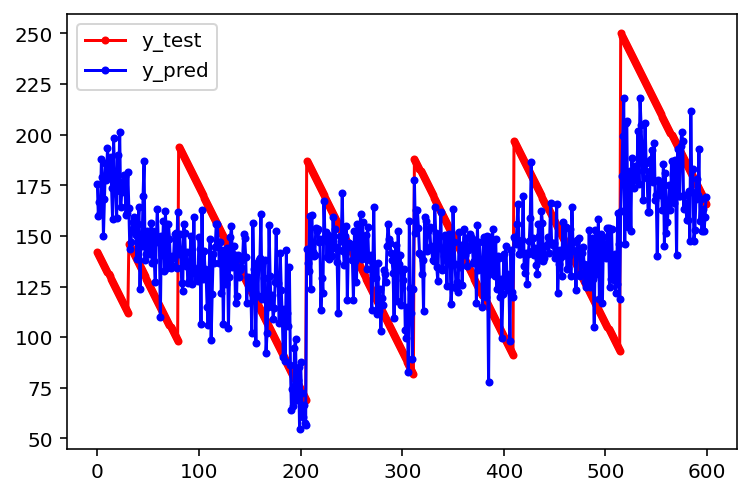

In [ ]:
rfr = RandomForestRegressor(50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_regression_result(y_test, y_pred, 600)

MAE= 34.342567193602385
rmse= 45.85176048443863
max error= 212.55463582580006
R2= 0.39558674864328836


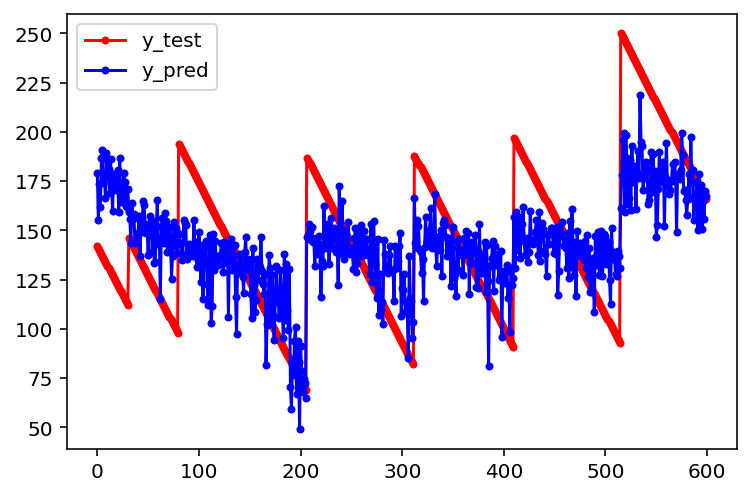

In [ ]:
lgbm_r = LGBMRegressor(n_estimators=300)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test),
           early_stopping_rounds=20, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred,600)

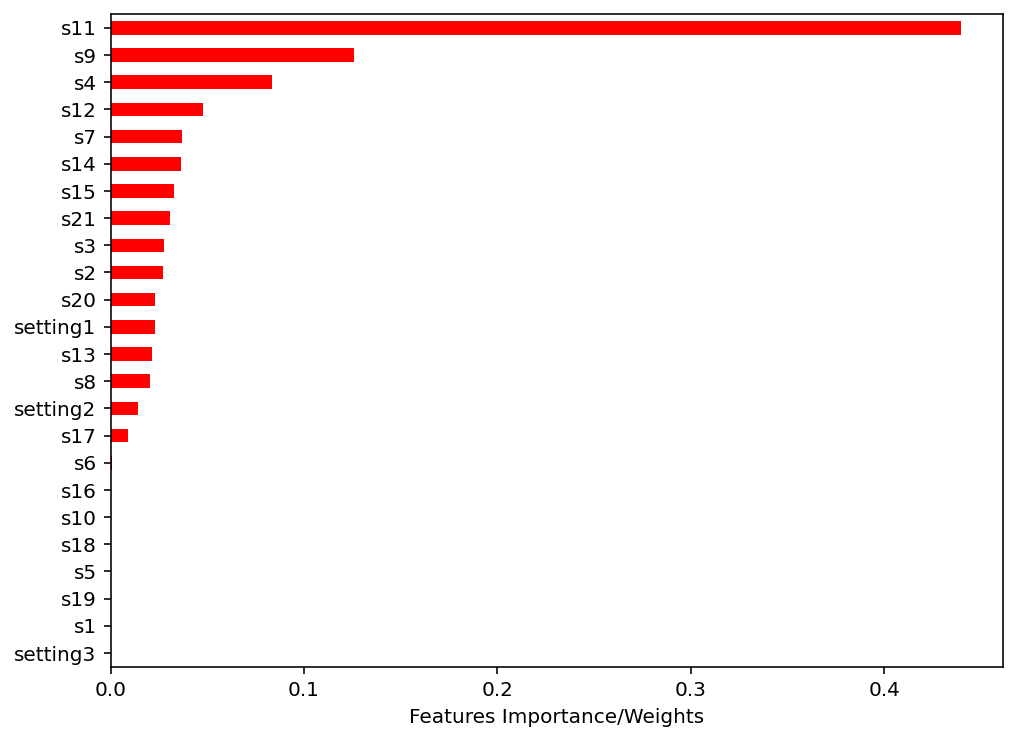

In [ ]:
plot_features_weights(X_train.columns, rfr.feature_importances_)

## 분류 모델

In [ ]:
y_train = train_df['label1']
y_test = test_df['label1']

In [ ]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
rfc = RandomForestClassifier(max_depth=15)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [ ]:
show_clf_result(y_test, y_pred)

[[12725    39]
 [  130   202]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.84      0.61      0.71       332

    accuracy                           0.99     13096
   macro avg       0.91      0.80      0.85     13096
weighted avg       0.99      0.99      0.99     13096



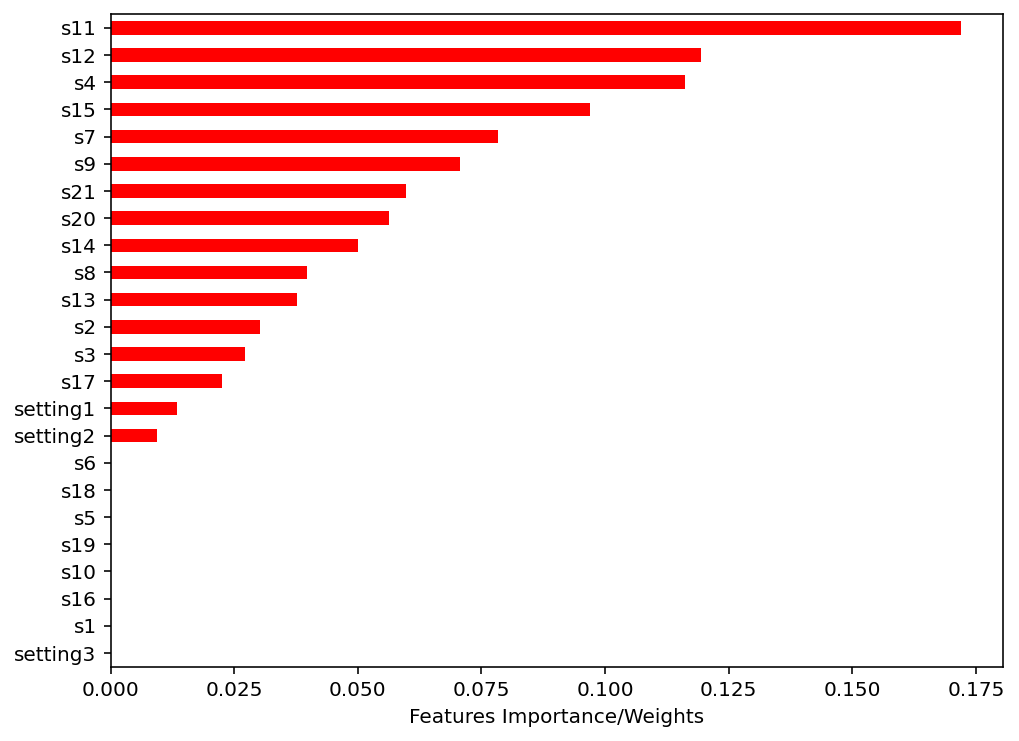

In [ ]:
plot_features_weights(X_train.columns, rfc.feature_importances_)

## 특성 추가
- 이동평균, 이동분산 등의 컬럼을 추가해본다


In [ ]:
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    df_av.columns = [col + "_av" + str(window) for col in df.columns]
    return df_av
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    df_std.columns = [col + "_std" + str(window) for col in df.columns]
    return df_std

## 훈련데이터 특성 추가
- 이동평균과 이동분산 추가 윈도우;15, 30

In [ ]:
window = 15
add1 = rolling_average(X_train, window)
add2 = rolling_std(X_train, window)
X_train_ext = pd.concat((X_train, add1, add2), axis=1)
X_train_ext.shape

(20631, 72)

In [ ]:
window = 30
add3 = rolling_average(X_train, window)
add4 = rolling_std(X_train, window)
X_train_ext2 = pd.concat((X_train_ext, add3, add4), axis=1)
X_train_ext2.shape

(20631, 120)

- 테스트 데이터 특성 추가

In [ ]:
add1 = rolling_average(X_test, window)
add2 = rolling_std(X_test, window)
X_test_ext = pd.concat((X_test, add1, add2), axis=1)
X_test_ext.shape

(13096, 72)

In [ ]:
window = 30
add3 = rolling_average(X_test, window)
add4 = rolling_std(X_test, window)
X_test_ext2 = pd.concat((X_test_ext, add3, add4), axis=1)
X_test_ext2.shape

(13096, 120)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_ext2, y_train)
y_pred = rfc.predict(X_test_ext2)
show_clf_result(y_test, y_pred)

[[12752    12]
 [  159   173]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.94      0.52      0.67       332

    accuracy                           0.99     13096
   macro avg       0.96      0.76      0.83     13096
weighted avg       0.99      0.99      0.99     13096



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- s10_av15
- s10_std15
- s11_av15
- s11_std15
- s12_av15
- ...

  warnings.warn(message, FutureWarning)


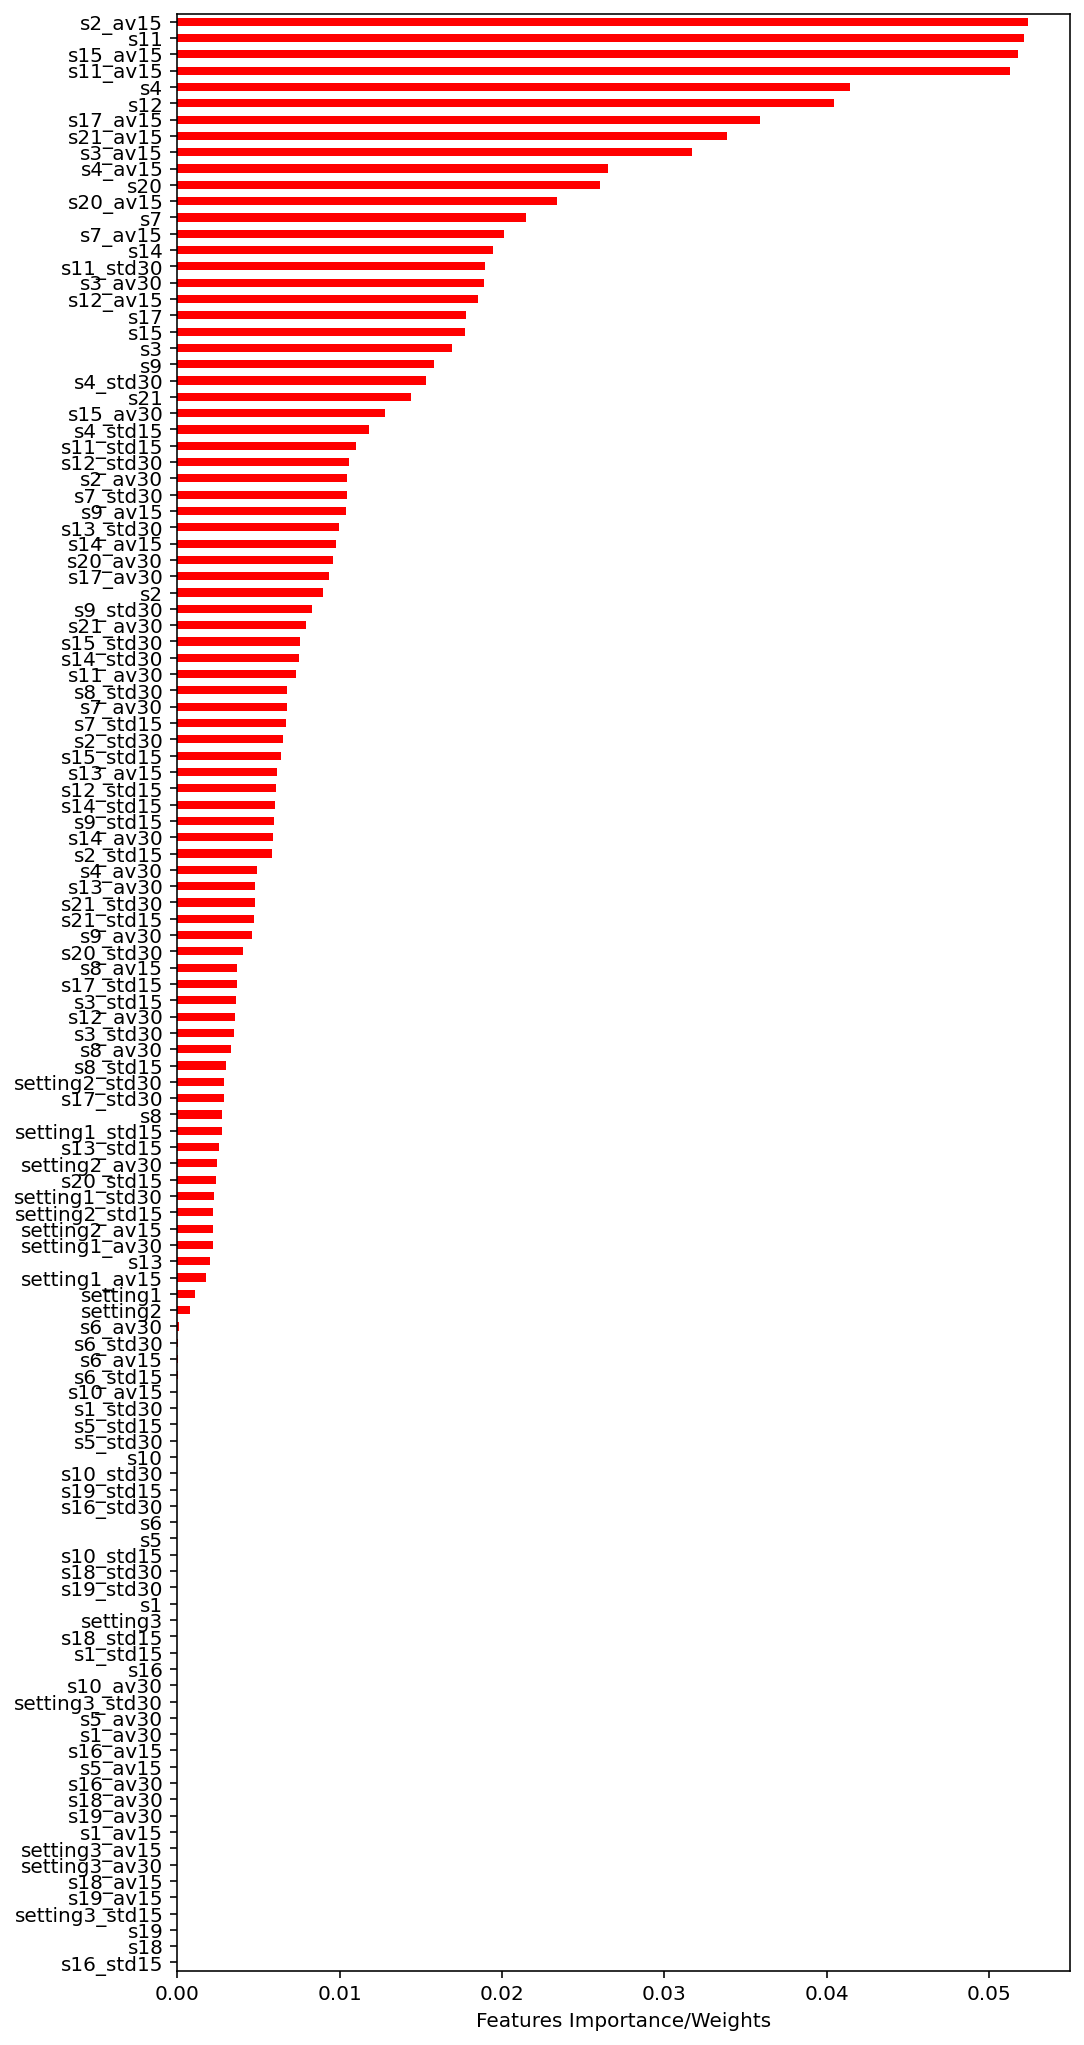

In [ ]:
plot_features_weights(X_train_ext2.columns, rfc.feature_importances_)

## 10개의 특성만 사용

In [ ]:
# 특성 10개 선택
features = ['s2','s4','s7','s9','s11','s12','s14','s15','s20','s21']
X_train = train_df[features]
X_test = test_df[features]

# 이후 위의 내용을 다시 수행

In [ ]:
window = 15
add1 = rolling_average(X_train, window)
add2 = rolling_std(X_train, window)
X_train_ext = pd.concat((X_train, add1, add2), axis=1)

window = 30
add3 = rolling_average(X_train, window)
add4 = rolling_std(X_train, window)
X_train_ext2 = pd.concat((X_train_ext, add3, add4), axis=1)

window = 15
add1 = rolling_average(X_test, window)
add2 = rolling_std(X_test, window)
X_test_ext = pd.concat((X_test, add1, add2), axis=1)

window = 30
add3 = rolling_average(X_test, window)
add4 = rolling_std(X_test, window)
X_test_ext2 = pd.concat((X_test_ext, add3, add4), axis=1)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_ext2, y_train)
y_pred = rfc.predict(X_test_ext2)
show_clf_result(y_test, y_pred)

[[12729    35]
 [  113   219]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.86      0.66      0.75       332

    accuracy                           0.99     13096
   macro avg       0.93      0.83      0.87     13096
weighted avg       0.99      0.99      0.99     13096



# LSTM 사용

- LSTM 윈도우를 충분히 크게 잡으면 윈도우 내의 중요한 신호를 파악하여 사용할 수 있다
- 장단기 신호를 전파할 수 있다.
- 단순히 이동평균을 사용하면 하나의 정보만 남게되어 스무딩된다

## 임의의 시퀀스를 n_steps 크기로 나누는 함수

- (주의) 아래 함수는 마지막 샘플은 포함하지 않는다
- 현재 데이터로 현재를 예측하는 것이 맞는지는 응용에 따라서 점검해야 한다

In [ ]:
def split_seq(sequence, n_steps):
  x = []
  for i in range(len(sequence)- n_steps):
    x.append(sequence[i:i+ n_steps])
  return np.array(x)

In [ ]:
# 예제
x = np.arange(20).reshape(-1,2)
inp = split_seq(x,4)
inp.shape

(6, 4, 2)

In [ ]:
x

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [ ]:
inp

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7]],

       [[ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9]],

       [[ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13]],

       [[ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15]],

       [[10, 11],
        [12, 13],
        [14, 15],
        [16, 17]]])

- LSTM 신경망은 (samples, time steps, features) 구조의 입력를 필요로 한다

## 입력 시퀀스 만들기

In [ ]:
n_steps = 50
res = []
for id in train_df['id'].unique():
  res.append(split_seq(train_df[train_df['id']==id][features], n_steps))
seq_array = np.concatenate(res)
seq_array.shape

(15631, 50, 10)

In [ ]:
train_df.shape

(20631, 29)

## 회귀 모델

In [ ]:
# 회귀 레이블 얻기
res2 = []
label = ["RUL"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

- r2 값을 모니터링한다

In [ ]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
seq_array.shape

(15631, 50, 10)

In [ ]:
nb_features = seq_array.shape[2] # 24
nb_out = label_array.shape[1]   # 1

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features), # (50, 24)
         units=100,                          # 뉴런의 수, 셀의 수
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1)) # 1
model.add(Activation("linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           44400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 74,651
Trainable params: 74,651
Non-traina

In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='min')])

print(history.history.keys())

Epoch 1/100
75/75 - 6s - loss: 8864.2617 - mae: 75.4706 - r2_keras: -1.7335e+00 - val_loss: 8283.4082 - val_mae: 72.6028 - val_r2_keras: -2.4868e+00 - 6s/epoch - 82ms/step
Epoch 2/100
75/75 - 1s - loss: 8189.3521 - mae: 71.5445 - r2_keras: -1.5175e+00 - val_loss: 7753.0283 - val_mae: 69.5191 - val_r2_keras: -2.2361e+00 - 750ms/epoch - 10ms/step
Epoch 3/100
75/75 - 1s - loss: 7671.6729 - mae: 68.5616 - r2_keras: -1.3610e+00 - val_loss: 7255.1357 - val_mae: 66.6404 - val_r2_keras: -2.0026e+00 - 729ms/epoch - 10ms/step
Epoch 4/100
75/75 - 1s - loss: 7183.5977 - mae: 65.7757 - r2_keras: -1.2115e+00 - val_loss: 6783.5142 - val_mae: 63.9321 - val_r2_keras: -1.7834e+00 - 736ms/epoch - 10ms/step
Epoch 5/100
75/75 - 1s - loss: 6728.5479 - mae: 63.2053 - r2_keras: -1.0718e+00 - val_loss: 6343.8052 - val_mae: 61.4265 - val_r2_keras: -1.5812e+00 - 746ms/epoch - 10ms/step
Epoch 6/100
75/75 - 1s - loss: 6298.8164 - mae: 60.7657 - r2_keras: -9.4490e-01 - val_loss: 5932.6699 - val_mae: 59.1028 - val_r

In [ ]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)

79/79 [==============================] - 1s 5ms/step


In [ ]:
def show_mae(history):
    plt.plot(history.history['mae'], 'r', label='mae')
    plt.plot(history.history['val_mae'], 'b', label='val_mae')
    plt.ylim(0)
    plt.legend()
    plt.show()
def show_r2(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['r2_keras'], 'r--', label='train_r2')
    plt.plot(history.history['val_r2_keras'], 'b--', label='val_r2')
    plt.ylim(0)
    plt.legend()
    plt.show()

MAE= 17.230003855109604
rmse= 25.606926623444338
max error= 149.18934631347656
R2= 0.7991818741555992


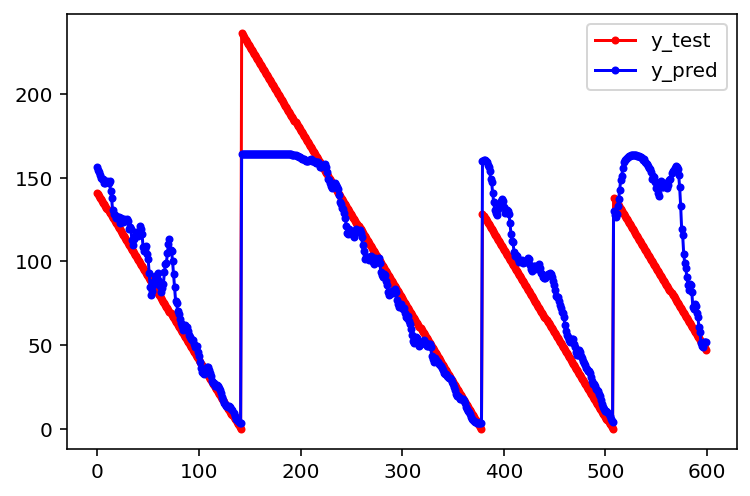

In [ ]:
show_regression_result(label_array.ravel(), y_pred.ravel(),600)

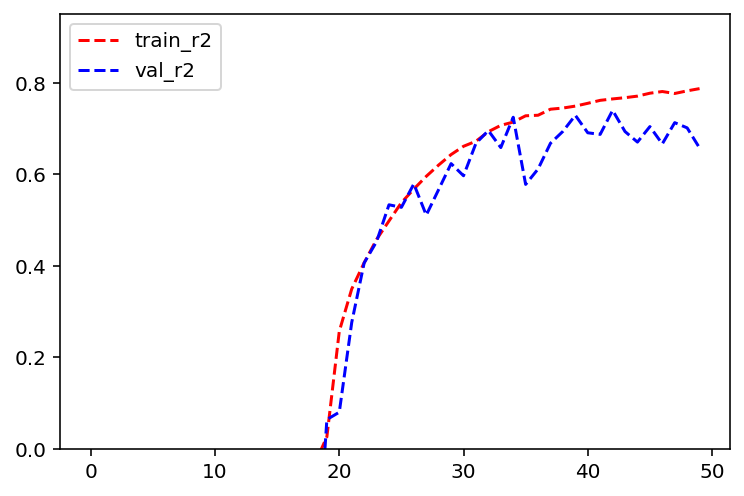

In [ ]:
show_r2(history)

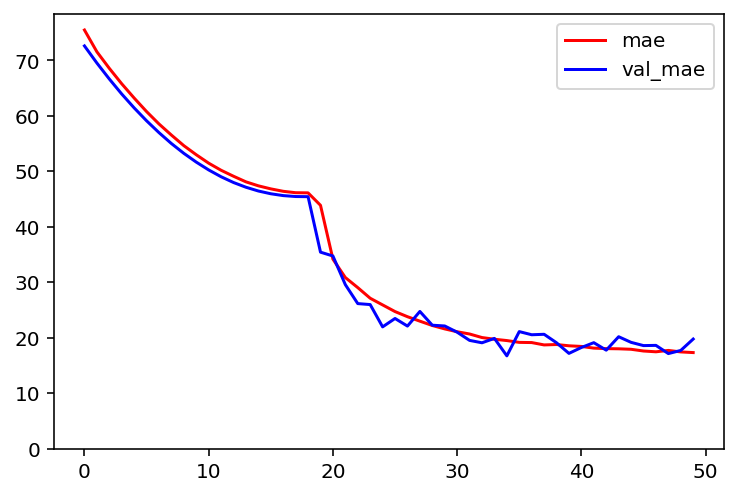

In [ ]:
show_mae(history)

## 테스트 데이터에 적용
- 테스트 데이터의 각 엔진별 마지막 50 샘플을 입력으로 사용한다
- 마지막 샘플수가 50보다 작은 경우는 테스트할 수 없다

In [ ]:
sequence_cols = features
sequence_length = 50
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 10)

In [ ]:
# test_df의 마지막 샘플의 크기가 50 이상인지를 확인
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
len(y_mask), np.array(y_mask).sum()

(100, 93)

- 회귀 레이블 얻기

In [ ]:
test_df.groupby('id')['RUL'].nth(-1)[y_mask].values

array([ 69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,  83,  84,
        50,  28,  87,  16,  57, 113,  20, 119,  66,  97,  90, 115,   8,
        48, 106,   7,  11,  19,  21,  50,  28,  18,  10,  59, 109, 114,
        47, 135,  92,  21,  79, 114,  29,  26,  97, 137,  15, 103,  37,
       114, 100,  21,  54,  72,  28, 128,  14,  77,   8, 121,  94, 118,
        50, 131, 126, 113,  10,  34, 107,  63,  90,   8,   9, 137,  58,
        89, 116, 115, 136,  28,  38,  20,  85,  55, 128, 137,  82,  59,
       117,  20])

In [ ]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 10)
(93, 1)


In [ ]:
# 회귀 성능
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('mae=', scores_test[1], 'r2=', scores_test[2])

3/3 - 1s - loss: 503.8076 - mae: 16.5565 - r2_keras: 0.6978 - 1s/epoch - 484ms/step
mae= 16.556501388549805 r2= 0.6977624893188477


## 이진 분류 모델

In [ ]:
# 이진분류 레이블 얻기
res2 = []
label = ["label1"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

In [ ]:
label_array

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

## LSTM 모델

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           44400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 74,651
Trainable params: 74,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
seq_array.shape, label_array.shape

((15631, 50, 10), (15631, 1))

In [ ]:
%%time
# fit the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')])

Epoch 1/100
75/75 [==============================] - 5s 22ms/step - loss: 0.2527 - accuracy: 0.8985 - val_loss: 0.1855 - val_accuracy: 0.9284
Epoch 2/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0983 - accuracy: 0.9601 - val_loss: 0.0745 - val_accuracy: 0.9706
Epoch 3/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0917 - accuracy: 0.9631 - val_loss: 0.0627 - val_accuracy: 0.9834
Epoch 4/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0929 - accuracy: 0.9613 - val_loss: 0.0642 - val_accuracy: 0.9731
Epoch 5/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0801 - accuracy: 0.9651 - val_loss: 0.0770 - val_accuracy: 0.9706
Epoch 6/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0875 - accuracy: 0.9627 - val_loss: 0.0559 - val_accuracy: 0.9770
Epoch 7/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0739 - accuracy: 0.9684 - val_loss: 0.1036 - val_accuracy: 0.9540
Epoch 

In [ ]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1)
label_array_test_last.shape

(93, 1)

In [ ]:
# 이진 분류 확률을 얻는다
y_pred_test = model.predict(seq_array_test_last)
show_clf_result(label_array_test_last, y_pred_test>0.5)

3/3 [==============================] - 1s 8ms/step
[[67  1]
 [ 2 23]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        68
           1       0.96      0.92      0.94        25

    accuracy                           0.97        93
   macro avg       0.96      0.95      0.96        93
weighted avg       0.97      0.97      0.97        93



In [ ]:
y_pred_test.round(3)

array([[0.008],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.008],
       [0.226],
       [0.   ],
       [0.996],
       [0.   ],
       [0.   ],
       [0.974],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [1.   ],
       [0.004],
       [0.   ],
       [1.   ],
       [0.999],
       [0.959],
       [0.515],
       [0.007],
       [0.656],
       [0.717],
       [0.998],
       [0.001],
       [0.   ],
       [0.001],
       [0.054],
       [0.   ],
       [0.   ],
       [0.993],
       [0.   ],
       [0.   ],
       [0.425],
       [0.693],
       [0.   ],
       [0.   ],
       [0.997],
       [0.   ],
       [0.131],
       [0.   ],
       [0.   ],
       [0.901],
       [0.011],
       [0.001],
       [0.833],
       [0.   ],
       [0.979],
       [0.   ],
       [1.   ],
       [

In [ ]:
# 테스트 데이터 이진분류 레이블 얻기
res3 = []
label = ["label1"]
for id in test_df['id'].unique():
  res3.append(test_df[test_df['id']==id][label][n_steps:len(test_df)])
label_test_array = np.concatenate(res3)
label_test_array.shape

(8162, 1)